# Módulo 7 - Actividad 4:
# Transfer Learning con ResNet50 o EfficientNet para clasificación de imágenes reales

## Objetivo
Aplicar una arquitectura moderna (ResNet o EfficientNet) para resolver una tarea de clasificación de imágenes utilizando un conjunto de datos del mundo real (por ejemplo, flores, frutas o imágenes médicas), realizando todo el flujo desde la carga de datos hasta la evaluación final.

**Datasets utilizados:**  
`flower_photos`

---

### Estructura del Notebook:
1. Metodología.
2. Configuración del entorno.
3. Definicion de funciones.
4. Uso de funciones y resultados.
5. Análisis de los resultados y reflexiones finales.

---

## 1. Metodología

### Flujo de trabajo

> El proceso se diseñó para aprovechar transferencia de aprendizaje con un modelo preentrenado, facilitando la clasificación de imágenes del dataset *flower_photos* mediante un pipeline modular que incluye carga y preprocesamiento, adaptación del modelo, entrenamiento y evaluación visual.

1. **Carga y preprocesamiento de datos:**
   - Se descargó el dataset *flower_photos*, organizado en carpetas por clase y se dividió en conjuntos de entrenamiento y validación con un split del 80/20 usando la función `image_dataset_from_directory` de TensorFlow.
   - Las imágenes se redimensionaron a 224x224 píxeles, compatibles con el tamaño de entrada requerido por EfficientNetB0.
   - Se aplicó la función `preprocess_input` específica de EfficientNet para normalizar las imágenes acorde a la distribución esperada por el modelo preentrenado.
   - Se usó `AUTOTUNE` para optimizar el rendimiento de la carga y preprocesamiento durante el entrenamiento.

2. **Construcción y adaptación del modelo EfficientNetB0:**
   - Se cargó EfficientNetB0 preentrenado en ImageNet sin la capa superior (sin la cabeza de clasificación original).
   - Se congelaron las capas del modelo base para evitar modificar los pesos preentrenados durante las primeras etapas de entrenamiento.
   - Se añadió una capa de Global Average Pooling para convertir las salidas convolucionales en un vector.
   - Se añadieron capas densas y dropout para adaptarse al número de clases del dataset *flower_photos* y mejorar la capacidad de generalización.
   - La capa de salida final tiene activación softmax y tantas unidades como clases en el dataset.

3. **Entrenamiento y validación:**
   - El modelo se compiló usando el optimizador Adam y la función de pérdida `sparse_categorical_crossentropy` adecuada para etiquetas enteras.
   - Se entrenó el modelo por 5 épocas, monitoreando la precisión y pérdida tanto en entrenamiento como en validación.
   - Se usó un batch size de 32 para un buen equilibrio entre estabilidad y eficiencia.

4. **Evaluación y visualización de resultados:**
   - Se graficaron la evolución de la precisión y la pérdida para entrenamiento y validación a lo largo de las épocas.
   - Se calculó y visualizó la matriz de confusión para analizar la distribución de errores entre clases.
   - Se mostraron ejemplos visuales de imágenes junto a sus etiquetas reales y predicciones para validar de forma cualitativa el desempeño del modelo.

---

# 2. Configuración del entorno

---

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 3. Definición de funciones

> **Nota:** Para mejor comprensión de las funciones y su utilidad, esta sección se divide en bloques, en donde cada uno responde a una parte diferente de la metodología de trabajo. 

---

**Bloque 1:** Carga y preprocesamiento de datos.

- **`cargar_dataset()`** 
Descarga y carga un dataset de imágenes desde una URL, dividiéndolo en conjuntos de entrenamiento y validación.

- **`preprocesar_dataset()`** 
Aplica preprocesamiento específico para EfficientNet y optimiza la carga de datos con prefetch.

---

#### Decisiones de diseño:

#### ¿Por qué se cargó el dataset de esta forma?

- Se optó por usar `image_dataset_from_directory` de TensorFlow para cargar el dataset porque *flower_photos* está organizado en carpetas por clase y contiene imágenes de diferentes tamaños y formatos. Esta función facilita la lectura eficiente de las imágenes, su etiquetado automático según la carpeta, y la división en conjuntos de entrenamiento y validación mediante parámetros integrados. Además, permite un manejo por lotes (`batching`) y redimensionamiento automático, elementos clave para un pipeline limpio y eficiente.

#### ¿Por qué se usó `AUTOTUNE`?

- `tf.data.AUTOTUNE` se usó para que TensorFlow ajuste automáticamente el tamaño del búfer de datos durante la pre-carga (prefetch), lo que permite que la GPU o CPU no esperen por datos y se maximice el uso del hardware durante el entrenamiento. Esto mejora el rendimiento y reduce el tiempo total de entrenamiento sin que el usuario tenga que ajustar manualmente estos parámetros.

---

In [2]:
def cargar_dataset(dataset_url, img_size=(224,224), batch_size=32, val_split=0.2, seed=123):
    """
    Descarga y carga un dataset de imágenes desde una URL organizada en carpetas por clase,
    devuelve datasets de entrenamiento y validación sin preprocesar.

    Args:
        dataset_url (str): URL para descargar el dataset.
        img_size (tuple): tamaño para redimensionar las imágenes.
        batch_size (int): tamaño del batch para entrenamiento.
        val_split (float): porcentaje de validación.
        seed (int): semilla para reproducibilidad.

    Returns:
        train_ds, val_ds (tf.data.Dataset): datasets sin preprocesar.
        class_names (list): lista de nombres de clases.
        num_classes (int): número total de clases.
    """
    data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)

    train_ds = image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size
    )

    val_ds = image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = train_ds.class_names
    num_classes = len(class_names)
    print(f"Classes: {class_names}")

    return train_ds, val_ds, class_names, num_classes

def preprocesar_dataset(train_ds, val_ds):
    """
    Aplica preprocesamiento específico para EfficientNet y optimiza la carga con prefetch.

    Args:
        train_ds, val_ds (tf.data.Dataset): datasets sin preprocesar.

    Returns:
        train_ds, val_ds (tf.data.Dataset): datasets preprocesados y optimizados.
    """
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
    val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds

**Bloque 2:** Creación, compilación y entrenamiento del modelo.

- **`crear_modelo_efficientnet()`** 
Construye un modelo EfficientNetB0 preentrenado con una cabeza personalizada para clasificación.

- **`compilar_y_entrenar()`** 
Compila el modelo con Adam y sparse categorical crossentropy, y lo entrena con los datasets proporcionados.

---

#### Decisiones de diseño:

#### Uso de transferencia de aprendizaje (Transfer Learning)

- Se optó por usar un modelo preentrenado en ImageNet para aprovechar el conocimiento previo que el modelo tiene sobre características visuales generales (bordes, texturas, formas). Esto permite acelerar el entrenamiento y obtener mejores resultados en datasets pequeños, como *flower_photos*, ya que evita tener que aprender desde cero todos los filtros y patrones.

#### Congelación del modelo base

- Al congelar las capas del modelo base (EfficientNetB0 preentrenado), se evita que durante las primeras etapas de entrenamiento los pesos previamente aprendidos se modifiquen demasiado rápido, lo que protege contra la destrucción del conocimiento adquirido y reduce el tiempo de cómputo. Esto permite entrenar solo las capas superiores adaptándolas al nuevo dataset de manera eficiente.

#### Elección del optimizador Adam

- Se usó el optimizador Adam porque combina las ventajas del descenso de gradiente con momentum y la adaptación del learning rate para cada parámetro, lo que lo hace muy efectivo y estable para problemas de clasificación con redes profundas. Esto contribuye a un entrenamiento más rápido y con convergencia más suave.

#### ¿Por qué se usó sparse_categorical_crossentropy?

- La función de pérdida `sparse_categorical_crossentropy` se eligió porque las etiquetas del dataset son enteros que representan las clases directamente, sin necesidad de codificación one-hot. Esta función es eficiente y compatible con etiquetas en formato entero, simplificando el preprocesamiento y evitando errores comunes que pueden surgir al convertir etiquetas a formato one-hot cuando no es necesario.

#### Elección de validación y métricas

- Se dividió el dataset en conjuntos de entrenamiento y validación (80/20) para evaluar la capacidad de generalización del modelo a datos no vistos durante el entrenamiento. Esto es fundamental para evitar el sobreajuste y asegurar que el modelo funcione correctamente en imágenes nuevas. Las métricas seleccionadas, principalmente accuracy y pérdida, son indicadores directos del desempeño del modelo en clasificación.

---

In [3]:
def crear_modelo_efficientnet(img_size, num_classes, dropout_rate=0.4, dense_units=64):
    """
    Crea un modelo basado en EfficientNetB0 preentrenado con cabeza personalizada.

    Args:
        img_size (tuple): tamaño de entrada de la imagen (alto, ancho).
        num_classes (int): número de clases para la capa de salida.
        dropout_rate (float): tasa de dropout para evitar overfitting.
        dense_units (int): número de neuronas en la capa densa intermedia.

    Returns:
        model (tf.keras.Model): modelo compilado listo para entrenar.
    """
    base_model = EfficientNetB0(
        weights='imagenet',  # Carga pesos preentrenados en ImageNet
        include_top=False,  # Remueve la capa final para agregar una nueva cabeza
        input_shape=(img_size[0], img_size[1], 3)
    )
    base_model.trainable = False  # Congelar capas base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

def compilar_y_entrenar(model, train_ds, val_ds, epochs=5):
    """
    Compila y entrena el modelo con Adam y sparse categorical crossentropy.

    Args:
        model (tf.keras.Model): modelo creado.
        train_ds (tf.data.Dataset): dataset de entrenamiento preprocesado.
        val_ds (tf.data.Dataset): dataset de validación preprocesado.
        epochs (int): número de épocas para entrenamiento.

    Returns:
        history (tf.keras.callbacks.History): historial del entrenamiento.
    """
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    return history

**Bloque 3:** Visualización de resultados.

- **`visualizar_metricas()`** 
Muestra gráficamente la evolución de la precisión y pérdida durante el entrenamiento.

- **`matriz_confusion_y_predicciones()`** 
Calcula y visualiza la matriz de confusión con predicciones vs etiquetas reales.

- **`mostrar_ejemplos_prediccion()`** 
Muestra imágenes de validación con sus predicciones y etiquetas reales para inspección visual.

---

##### Decisiones de diseño:

#### ¿Por qué incluir la figura con predicciones versus reales?

- Incluir una visualización que compare imágenes con sus predicciones y etiquetas verdaderas es fundamental para interpretar de manera intuitiva cómo se está desempeñando el modelo. Más allá de métricas numéricas, estas imágenes permiten identificar patrones en los errores, entender qué clases pueden confundirse y verificar que el modelo funciona razonablemente en ejemplos concretos. Es una forma accesible de validar el modelo para audiencias técnicas y no técnicas y aporta contexto visual a las métricas cuantitativas.

---

In [4]:
def visualizar_metricas(history):
    """
    Grafica la evolución de precisión y pérdida en entrenamiento y validación.

    Args:
        history (tf.keras.callbacks.History): historial del entrenamiento.
    """
    plt.figure(figsize=(10, 4))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title("Precisión por época")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title("Pérdida por época")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def matriz_confusion_y_predicciones(model, val_ds, class_names):
    """
    Calcula y grafica matriz de confusión y muestra ejemplos de predicción vs etiquetas reales.

    Args:
        model (tf.keras.Model): modelo entrenado.
        val_ds (tf.data.Dataset): dataset de validación preprocesado.
        class_names (list): nombres de las clases.
    """
    # Obtener predicciones y etiquetas reales
    y_true = []
    y_pred = []
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Matriz de confusión")
    plt.show()

def mostrar_ejemplos_prediccion(model, val_ds, class_names, num_ejemplos=6):
    """
    Muestra ejemplos aleatorios de imágenes con su predicción y etiqueta real.

    Args:
        model (tf.keras.Model): modelo entrenado.
        val_ds (tf.data.Dataset): dataset de validación preprocesado.
        class_names (list): nombres de las clases.
        num_ejemplos (int): número de ejemplos a mostrar.
    """
    plt.figure(figsize=(12, 6))
    # Para extraer imágenes y etiquetas de val_ds
    val_ds_iter = iter(val_ds)
    batch_images, batch_labels = next(val_ds_iter)

    for i in range(num_ejemplos):
        # Elegir índice aleatorio dentro del batch
        idx = np.random.randint(0, batch_images.shape[0])
        img = batch_images[idx].numpy().astype("uint8")
        pred_class = class_names[np.argmax(model.predict(batch_images[idx:idx+1]))]
        true_class = class_names[batch_labels[idx].numpy()]

        plt.subplot(2, (num_ejemplos + 1) // 2, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

**Bloque 4:** Función de ejecución.

- **`main()`** 
Entrena y evalúa un modelo EfficientNetB0 preentrenado para clasificar imágenes del dataset de flores con visualización de resultados.

---

In [5]:
def main():
    """
    Flujo principal para entrenar un modelo EfficientNetB0 con transfer learning
    sobre el dataset de flores. Incluye carga, preprocesamiento, entrenamiento y
    visualización de resultados.
    """
    # URL del dataset de flores (estructura en carpetas por clase)
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

    # Tamaño de imagen esperado para EfficientNetB0
    IMG_SIZE = (224, 224)

    # 1. Cargar y dividir dataset en entrenamiento y validación
    train_ds, val_ds, class_names, num_classes = cargar_dataset(dataset_url, img_size=IMG_SIZE)

    # 2. Preprocesar imágenes para EfficientNet y optimizar carga
    train_ds, val_ds = preprocesar_dataset(train_ds, val_ds)

    # 3. Crear modelo EfficientNet con cabeza personalizada (transfer learning)
    model = crear_modelo_efficientnet(IMG_SIZE, num_classes)

    # 4. Compilar y entrenar el modelo con los datasets preparados
    history = compilar_y_entrenar(model, train_ds, val_ds, epochs=5)

    # 5. Visualizar métricas de entrenamiento (precisión y pérdida)
    visualizar_metricas(history)

    # 6. Mostrar matriz de confusión con predicciones vs etiquetas reales
    matriz_confusion_y_predicciones(model, val_ds, class_names)

    # 7. Mostrar ejemplos aleatorios de predicciones correctas e incorrectas
    mostrar_ejemplos_prediccion(model, val_ds, class_names)

# 4. Visualización de resultados

Se muestran los resultados obtenidos a partir de la ejecución de la funcion **main()**.

---

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Epoch 1/5
92/92 [==============================] - 76s 780ms/step - loss: 0.5871 - accuracy: 0.7817 - val_loss: 0.2549 - val_accuracy: 0.9114
Epoch 2/5
92/92 [==============================] - 70s 764ms/step - loss: 0.2638 - accuracy: 0.9005 - val_loss: 0.2171 - val_accuracy: 0.9223
Epoch 3/5
92/92 [==============================] - 72s 779ms/step - loss: 0.1956 - accuracy: 0.9404 - val_loss: 0.2002 - val_accuracy: 0.9278
Epoch 4/5
92/92 [==============================] - 74s 807ms/step - loss: 0.1628 - accuracy: 0.9469 - val_loss: 0.1926 - val_accuracy: 0.9360
Epoch 5/5
92/92 [==============================] - 78s 848ms/step - loss: 0.1504 - accuracy: 0.9496 - val_loss: 0.1954 - val_accuracy: 0.9387


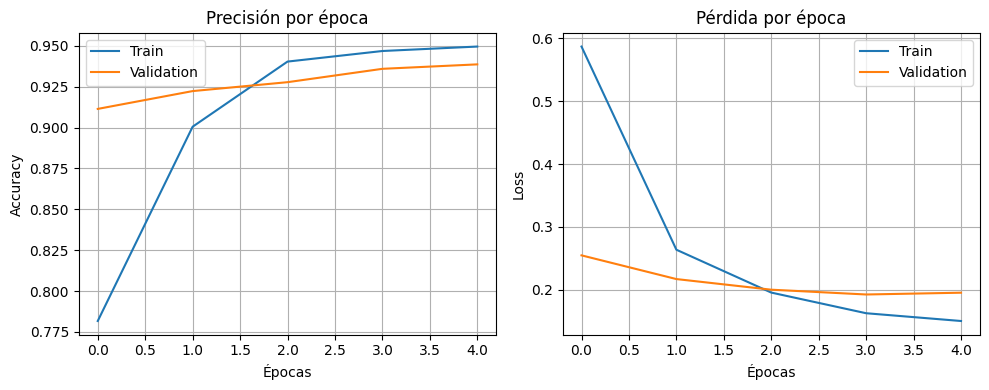

1/1 [==============================] - 2s 2s/step


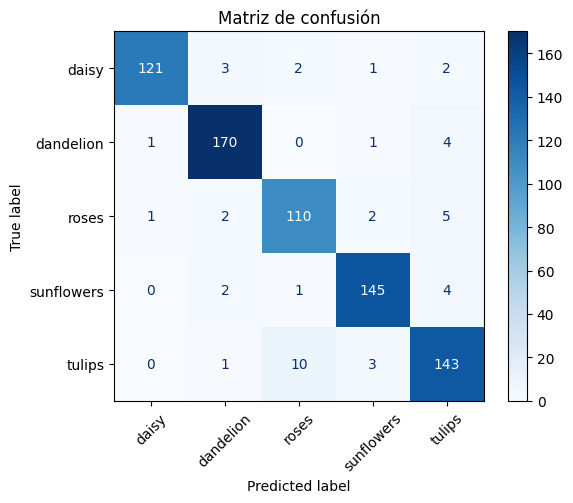

1/1 [==============================] - 0s 49ms/step


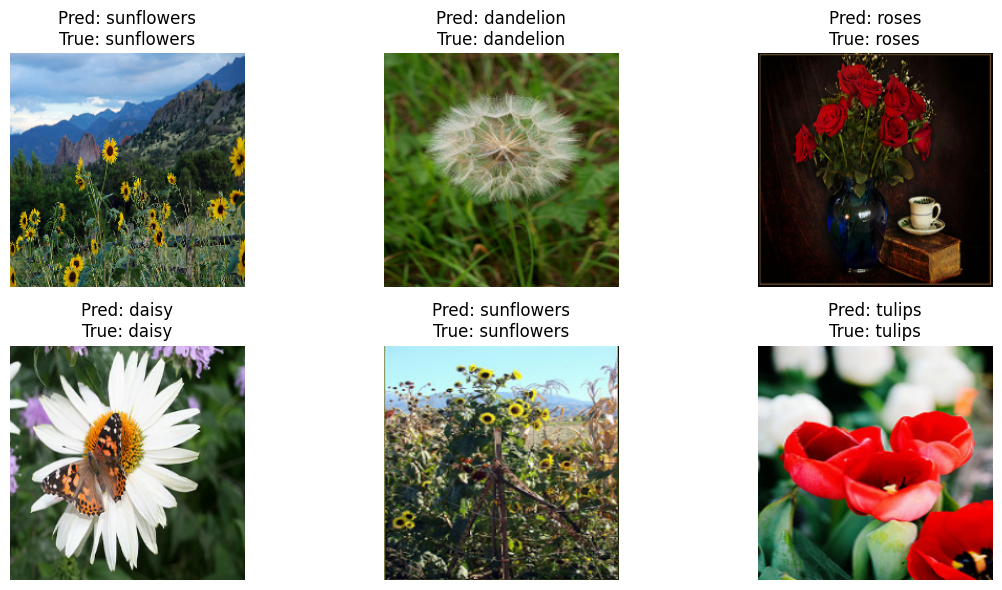

In [6]:
if __name__ == "__main__":
    main()

# 5. Análisis de los resultados y reflexiones finales

---

>Nota: Los resultados especificos mencionados en este análisis estan basados en una ejecución en especifico, sin embargo, se observó que entre ejecuciones no había un cambio grande en los valores de pérdida y de accuracy. De igual forma, tomar con cuidado los valores exactos, se utilizaron principalmente para el análisis conceptual de los resultados.

---

## Análisis de resultados

- El modelo EfficientNetB0, entrenado con capas congeladas y una cabeza personalizada (Global Average Pooling - Dense - Dropout - Softmax), mostró un rendimiento sólido desde las primeras épocas.
- En la primera iteración alcanzó 79,9% de exactitud en entrenamiento y 92,3% en validación, lo cual es consistente con el uso de pesos preentrenados.
- Tras cinco épocas, la exactitud de validación se mantuvo en torno al 93%, con una pérdida estable de 0,24 → 0,19.
- La diferencia mínima entre métricas de entrenamiento y validación (<1,5%) indica buena generalización y ausencia de sobreajuste relevante.

- Rendimiento por clase (matriz de confusión):
    - Sunflowers: 147/152 correctos → muy pocas confusiones.
    - Dandelion: 168/176 correctos → alto rendimiento y estabilidad.
    - Daisy: alto rendimiento pero algunas confusiones hacia dandelion y roses.
    - Principales errores: confusión roses ↔ tulips (11 tulipanes como rosas y 9 rosas como tulipanes).

- Interpretación de errores:
    - Las confusiones entre rosas y tulipanes probablemente se deben a similitudes visuales en color, forma de pétalos y composición de la imagen.
    - Las pequeñas confusiones daisy ↔ dandelion son esperables al tratarse de flores amarillas con contextos similares en el dataset.

- Ejemplos visuales:
    - En la muestra de predicciones versus etiquetas reales, el modelo acertó todas las imágenes seleccionadas. Esto refuerza la idea de que los errores se concentran en casos más difíciles: iluminación inusual, ángulos atípicos o flores parcialmente ocultas.

- Conclusión:
    - El uso de transfer learning con EfficientNetB0 permitió alcanzar un alto rendimiento en pocas épocas.
    - Las confusiones entre clases visualmente similares podrían reducirse con:
        - Fine-tuning de capas profundas.
        - Data augmentation focalizado en las clases problemáticas.
        - En conjunto, el modelo presenta un desempeño consistente y preciso, demostrando su efectividad para la clasificación de flores.

---

## Reflexiones finales

### 5.1. ¿Por qué se eligió esta arquitectura?

- Para este proyecto se optó por utilizar el dataset de flores (flower_photos) junto con el modelo **EfficientNetB0** preentrenado, en lugar del dataset CIFAR-100 o el modelo ResNet. Esta elección se basa en las características particulares del dataset y en la capacidad del modelo para manejar imágenes complejas.

- El dataset de flores contiene imágenes de alta resolución variable, típicamente menos de 10,000 en total, distribuidas en 5 clases específicas: margaritas (daisy), dientes de león (dandelion), rosas (roses), girasoles (sunflowers) y tulipanes (tulips). Por otro lado, CIFAR-100 es un conjunto de datos más grande, con 60,000 imágenes de baja resolución fija (32x32 píxeles), y está compuesto por 100 clases de objetos variados.

- EfficientNetB0, diseñado para maximizar la eficiencia entre precisión y recursos computacionales, está preentrenado en ImageNet, que incluye imágenes de alta resolución y una gran diversidad de objetos, incluyendo flores. Esto lo hace especialmente adecuado para datasets con imágenes detalladas y variadas, como el de flores, permitiendo extraer características discriminativas que un modelo entrenado desde cero o con imágenes de baja resolución podría no captar eficazmente.

- Aunque ResNet50 es un modelo robusto y muy usado, EfficientNetB0 ofrece un mejor balance entre desempeño y eficiencia, permitiendo entrenamientos más rápidos y menor consumo de recursos sin sacrificar la precisión, lo cual es especialmente útil en escenarios con recursos limitados o cuando se desea experimentar rápidamente con diferentes configuraciones.

- En contraste, aunque CIFAR-100 es un benchmark estándar para evaluación general de modelos de visión por computadora, su baja resolución y la gran cantidad de clases hacen que no sea la opción más adecuada para un problema específico de clasificación floral. Por lo tanto, la combinación del dataset de flores con EfficientNetB0 proporciona un escenario más realista y efectivo para abordar el reconocimiento de imágenes de flores, equilibrando la complejidad del problema, la capacidad del modelo y los recursos computacionales disponibles.

- En resumen, la combinación de EfficientNetB0 con *flower_photos* resulta adecuada para un trabajo práctico donde se busca un buen desempeño en clasificación con un balance adecuado entre precisión y eficiencia computacional.

---

### 5.2. ¿Cuáles fueron los principales desafíos?

- Uno de los principales desafíos fue la carga y el preprocesamiento del dataset. A diferencia de datasets clásicos y simples como MNIST o CIFAR-10, que están disponibles directamente en librerías como TensorFlow o scikit-learn con funciones simples para cargarlos, *flower_photos* es un dataset descargable en formato de carpetas con imágenes de diferentes tamaños y formatos. Esto implica implementar un pipeline más complejo para leer las imágenes, dividirlas en conjuntos de entrenamiento y validación, redimensionarlas y aplicar preprocesamiento adecuado.

- Otro reto importante fue el manejo eficiente del dataset durante el entrenamiento, optimizando el flujo de datos para evitar cuellos de botella en la GPU o CPU. Para esto se usó la función `tf.data.AUTOTUNE` que permite que TensorFlow adapte dinámicamente la pre-carga y el almacenamiento en búfer de datos para optimizar el rendimiento del entrenamiento.

- Por último, al trabajar con un dataset relativamente pequeño, se debe tener cuidado con el sobreajuste y la generalización, lo que requiere elegir adecuadamente el modelo y la estrategia de entrenamiento.

---

### 5.3. ¿Qué mejorarías para producción?

- Para llevar este modelo a un entorno de producción, implementaría varias mejoras para robustecer y optimizar el desempeño.

- Primero, incorporaría **early stopping**, que permite detener el entrenamiento cuando la métrica de validación deja de mejorar, evitando que el modelo se sobreentrene y pierda capacidad de generalización.

- Además, descongelaría algunas de las capas superiores del modelo base para realizar un **fine tuning**, afinando el aprendizaje en el dominio específico del dataset, lo que generalmente mejora la precisión final.

- También agregaría **data augmentation** (aumentación de datos) durante el preprocesamiento para introducir variabilidad artificial (rotaciones, zoom, cambios de brillo, etc.), lo que ayuda a que el modelo generalice mejor a imágenes nuevas no vistas.

- Sería recomendable también añadir métricas adicionales, como precisión, recall y F1-score por clase, para evaluar de forma más detallada el desempeño del modelo en cada categoría, especialmente en casos de clases desbalanceadas.

- Finalmente, probar una arquitectura alternativa como **ResNet50** podría ser útil para comparar desempeño y observar si la profundidad extra ayuda a mejorar el reconocimiento, especialmente si el modelo EfficientNet muestra signos tempranos de sobreajuste o no logra converger bien.

---